In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pprint import pprint

sns.set(style="whitegrid")

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_columns', None)

In [4]:
#Read in a bunch of csv files and stack them together

path =r'C:\\Users\\armcl\\Python\\Lending Club\\Data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [5]:
#Remove all NAs data
lc_all.dropna(subset=['loan_status'], inplace=True)

#int rate to numeric
lc_all['int_rate'] = pd.to_numeric(lc_all['int_rate'].str.replace("%", "").str.replace(" ", ""))

#Extract the initiation year feature
lc_all['issue_d'] = pd.to_datetime(lc_all['issue_d'])
lc_all['last_pymnt_d'] = pd.to_datetime(lc_all['last_pymnt_d'])
lc_all['issue_y'] = lc_all['issue_d'].dt.year

#Defaulted loans are tiny and let's relabel them to charge off
lc_all['loan_status'].replace({'Default':'Charged Off'}, inplace=True)

In [6]:
#Current loans are not necessarily going to be fully paid
#Only include loans that are either fully paid or charged off in this analysis

lc_all = lc_all.loc[lc_all['loan_status'].isin(['Fully Paid','Charged Off']),:]

In [7]:
#Avoid data leakage (remove features that were unknown at the time of the loan initiaion)
leakage_features = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high',
                    'last_fico_range_low','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',
                    'num_tl_120dpd_2m','num_tl_30dpd','out_prncp','out_prncp_inv',
                    'recoveries','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','total_rec_prncp','debt_settlement_flag',
                    'debt_settlement_flag_date','settlement_status','settlement_date',
                    'settlement_amount','settlement_percentage','settlement_term']

#Remove features that don't have much added information
#For example sub_grade is finer than grade
features_to_remove = leakage_features + ['emp_title','loan_amnt','funded_amnt_inv','grade',
                                         'id','member_id','title','url','zip_code',
                                         'pymnt_plan','policy_code']

lc_all = lc_all.drop(columns=features_to_remove)


In [8]:
#If join application, replace with the joint info

lc_all['revol_util'] = pd.to_numeric(lc_all['revol_util'].str.replace("%", ""))

lc_all.loc[lc_all['application_type']=='Joint App','annual_inc'] = lc_all.loc[lc_all['application_type']=='Joint App','annual_inc_joint']
lc_all.loc[lc_all['application_type']=='Joint App','dti'] = lc_all.loc[lc_all['application_type']=='Joint App','dti_joint']
lc_all.loc[lc_all['application_type']=='Joint App','verification_status'] = lc_all.loc[lc_all['application_type']=='Joint App','verification_status_joint']

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal'] = lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal_joint']
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'sec_app_fico_range_low'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'sec_app_fico_range_high'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'sec_app_inq_last_6mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'sec_app_mort_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'sec_app_open_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'sec_app_revol_util'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'sec_app_open_act_il'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'sec_app_num_rev_accts'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'sec_app_chargeoff_within_12_mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'sec_app_collections_12_mths_ex_med'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'sec_app_mths_since_last_major_derog'])/2

In [9]:
#Reduce the number of categories for home ownership
lc_all = lc_all.replace({'home_ownership' : {'ANY':'OTHER','NONE':'OTHER'}})

#Create dummy variables

lc_all = pd.concat([lc_all, lc_all['term'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, lc_all['sub_grade'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['home_ownership'],prefix="Home")], axis=1)
lc_all = pd.concat([lc_all, lc_all['verification_status'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['purpose'],prefix="purpose")], axis=1)
lc_all = pd.concat([lc_all, lc_all['addr_state'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['initial_list_status'],prefix="list_status")], axis=1)
lc_all = pd.concat([lc_all, lc_all['application_type'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, lc_all['loan_status'].str.get_dummies(sep=',')], axis=1)

In [10]:
#Replace categorical variables to numerical
lc_all = lc_all.replace({'emp_length' : {'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':15}})

#Create a few new features

lc_all['loan_desc_length'] = lc_all['desc'].str.len().fillna(0)

lc_all['earliest_cr_line'] = pd.to_datetime(lc_all['earliest_cr_line'])
lc_all['cr_line_months'] = lc_all['issue_d'] - lc_all['earliest_cr_line']
lc_all['cr_line_months']=round(lc_all['cr_line_months']/np.timedelta64(1,'M'),2)

lc_all['sec_app_earliest_cr_line'] = pd.to_datetime(lc_all['sec_app_earliest_cr_line'])
lc_all['sec_app_cr_line_months'] = lc_all['issue_d'] - lc_all['sec_app_earliest_cr_line']
lc_all['sec_app_cr_line_months']=round(lc_all['sec_app_cr_line_months']/np.timedelta64(1,'M'),2)

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'sec_app_cr_line_months'])/2

lc_all['fico_range_avg'] = (lc_all['fico_range_low'] + lc_all['fico_range_high'])/2

#And remove the joint data
features_to_remove = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                      'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog','sec_app_cr_line_months',
                      'sec_app_earliest_cr_line']

lc_all = lc_all.drop(columns=features_to_remove)

In [11]:
#No hardship application for paid off and charged off loans, remove the irrelvant features
lc_all = lc_all.drop(lc_all.loc[:, 'hardship_flag':'hardship_last_payment_amount'].columns, axis = 1) 

#remove new features with data only after 2015
#can't fill the NaNs before 2015 since it's not randomly missing
#might worth only looking at the post 2015 data and see if any of these are important
lc_all = lc_all.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
                       'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                       'all_util','inq_fi','total_cu_tl','inq_last_12m'])

In [13]:
#Fill Nas
#For these features, the longer the better

features_to_inverse = ['mths_since_recent_inq','mo_sin_old_il_acct',
                      'mo_sin_old_rev_tl_op','mths_since_last_delinq','mths_since_last_record',
                      'mths_since_last_major_derog','mths_since_rcnt_il','mths_since_recent_bc_dlq',
                      'mths_since_recent_revol_delinq']

for col in features_to_inverse:
    lc_all[col] = lc_all[col].fillna(2*lc_all[col].max())
    
#Remove all NAs data
lc_all.dropna(subset=['tot_coll_amt'], inplace=True)

#Features from open_acc_6m to inq_last_12m are new features released after 2015
#Use median for the 2007-2018 sample; worth only looking at the 2015-2018 sample to see if any significance

replace_median = ['dti','inq_last_6mths','revol_util',
                  'emp_length',
                  'bc_open_to_buy','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                  'bc_util','chargeoff_within_12_mths','mths_since_recent_bc','num_rev_accts',
                  'pct_tl_nvr_dlq','percent_bc_gt_75'
                  ]

for col in replace_median:
    lc_all[col] = lc_all[col].fillna(lc_all[col].median())


In [14]:
#Drop state dummy variables with less than 10000 loans in the data

bystate = lc_all.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)
small_state = list(bystate[bystate['funded_amnt']<10000].index)
lc_all = lc_all.drop(columns=small_state)

#Remove observations with annual income lower than $8000 and higher than $300k
lc_all = lc_all.loc[(lc_all['annual_inc'] > 8000) & (lc_all['annual_inc'] < 300000),:]

#Create a new feature which is installment/annual income/12
lc_all['installment_to_inc'] = 100*lc_all['installment']/(lc_all['annual_inc']/12)

#dti can't be negative
lc_all = lc_all.loc[lc_all['dti'] > 0,:]

In [15]:
#Excluding current loans, on average about 20% of all loans were charged off

lc_all.loan_status.value_counts()/lc_all.loan_status.value_counts().sum()

Fully Paid     0.801494
Charged Off    0.198506
Name: loan_status, dtype: float64

In [16]:
#Remove unneeded features
features_to_remove = ['issue_d','earliest_cr_line','term','addr_state',
                      'sub_grade','home_ownership','verification_status',
                      'purpose','initial_list_status','application_type',
                      'Charged Off','Fully Paid','issue_y','desc',
                      'fico_range_high','fico_range_low','addr_state']
lc_all = lc_all.drop(columns=features_to_remove)

#Target 
lc_all = lc_all.replace({'loan_status' : {'Fully Paid':0,'Charged Off':1}})

In [17]:
lc_all.head(2)

,funded_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
42538,11100.0,14.98,384.68,15.0,90000.0,0,3.73,1.0,0.0,16.0,258.0,9.0,0.0,6619.0,66.2,12.0,0.0,16.0,0.0,0.0,353402.0,1022.0,10000.0,2.0,39267.0,1016.0,74.6,0.0,0.0,1998.0,150.0,11.0,11.0,1.0,11.0,35.0,11.0,35.0,1.0,4.0,8.0,4.0,4.0,0.0,8.0,11.0,8.0,9.0,1.0,1.0,75.0,50.0,0.0,0.0,385000.0,6619.0,4000.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0,150.02,692.0,5.129067
42539,12000.0,7.62,373.94,3.0,96500.0,0,12.61,0.0,0.0,452.0,258.0,17.0,0.0,13248.0,55.7,30.0,0.0,452.0,0.0,0.0,200314.0,1022.0,23800.0,4.0,11783.0,2441.0,83.5,0.0,0.0,123.0,118.0,10.0,9.0,1.0,10.0,404.0,10.0,404.0,0.0,4.0,5.0,4.0,10.0,15.0,8.0,14.0,5.0,17.0,0.0,3.0,100.0,100.0,0.0,0.0,233004.0,46738.0,14800.0,53404.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,186.0,123.01,707.0,4.650031


In [18]:
lc_all.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704569 entries, 42538 to 2778809
Data columns (total 157 columns):
funded_amnt                       1704569 non-null float64
int_rate                          1704569 non-null float64
installment                       1704569 non-null float64
emp_length                        1704569 non-null float64
annual_inc                        1704569 non-null float64
loan_status                       1704569 non-null int64
dti                               1704569 non-null float64
delinq_2yrs                       1704569 non-null float64
inq_last_6mths                    1704569 non-null float64
mths_since_last_delinq            1704569 non-null float64
mths_since_last_record            1704569 non-null float64
open_acc                          1704569 non-null float64
pub_rec                           1704569 non-null float64
revol_bal                         1704569 non-null float64
revol_util                        1704569 non-null float64

In [19]:
lc_all.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
count,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06
mean,1.457032e+04,1.322108e+01,4.402505e+02,7.666440e+00,7.635784e+04,1.985059e-01,1.829348e+01,3.197336e-01,6.119101e-01,2.439301e+02,2.259770e+02,1.166614e+01,2.163315e-01,1.642457e+04,5.074994e+01,2.468059e+01,1.958970e-02,3.407903e+02,4.814707e-03,2.432821e+02,1.385912e+05,4.873577e+02,3.303470e+04,4.665671e+00,1.328283e+04,1.076122e+04,5

In [20]:
lc_all.shape

(1704569, 157)

In [21]:
#Remove highly correlated features

target = ['loan_status'] 
features = list(lc_all.drop(['loan_status'],axis=1).columns)

corr_features = lc_all[features].corr()
np.fill_diagonal(corr_features.values, np.nan)
corr_features.unstack().sort_values(ascending=False).drop_duplicates()[0:20]

open_acc                  num_sats                          0.992965
num_actv_rev_tl           num_rev_tl_bal_gt_0               0.982792
tot_hi_cred_lim           tot_cur_bal                       0.972376
funded_amnt               installment                       0.951506
cr_line_months            mo_sin_old_rev_tl_op              0.912773
total_bal_ex_mort         total_il_high_credit_limit        0.887006
revol_util                bc_util                           0.851671
bc_open_to_buy            total_bc_limit                    0.847679
percent_bc_gt_75          bc_util                           0.845636
num_rev_accts             num_bc_tl                         0.836652
num_op_rev_tl             num_sats                          0.833886
                          open_acc                          0.830343
num_actv_bc_tl            num_bc_sats                       0.829340
avg_cur_bal               tot_cur_bal                       0.826725
num_actv_rev_tl           num_actv

In [22]:
#Remove the highly correlated feature

highly_cor_features = ['num_sats','num_rev_tl_bal_gt_0','tot_hi_cred_lim','installment']
lc_all = lc_all.drop(columns=highly_cor_features)

In [23]:
#Unbalanced data

lc_all['loan_status'].value_counts()/lc_all['loan_status'].value_counts().sum()

0    0.801494
1    0.198506
Name: loan_status, dtype: float64

In [24]:
#Tried to train models using 2012-2017 and test using 2018-2019
#Gives similar results (but 2018 and 2019 are predominantly 36 months loans and thus introducing bias potentially)

Random under-sampling:
1    338367
0    338367
Name: loan_status, dtype: int64


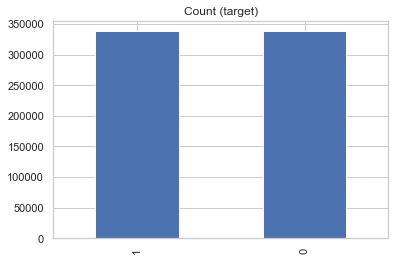

In [25]:
#Under-resampling to reduce imbalance
# Class count
count_0, count_1 = lc_all.loan_status.value_counts()

# Divide by class
df_class_0 = lc_all[lc_all['loan_status'] == 0]
df_class_1 = lc_all[lc_all['loan_status'] == 1]

# random sampling
df_class_0_under = df_class_0.sample(count_1)
lc_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(lc_under.loan_status.value_counts())

lc_under.loan_status.value_counts().plot(kind='bar', title='Count (target)');

In [26]:
# #Over-sampling for checking purposes, gives similar results
# # random sampling
# df_class_1_over = df_class_1.sample(count_0, replace=True)
# lc_over = pd.concat([df_class_0, df_class_1_over], axis=0)

# print('Random over-sampling:')
# print(lc_over.loan_status.value_counts())

# lc_over.loan_status.value_counts().plot(kind='bar', title='Count (target)');

In [27]:
lc_under.head(2)

,funded_amnt,int_rate,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
619983,8500.0,9.17,6.0,32333.0,0,30.96,0.0,0.0,75.0,74.0,9.0,1.0,9895.0,59.0,23.0,0.0,71.0,0.0,0.0,24647.0,1022.0,16650.0,5.0,2738.0,3250.0,94.0,0.0,0.0,144.0,166.0,4.0,3.0,4.0,28.0,404.0,11.0,404.0,1.0,3.0,8.0,3.0,4.0,8.0,8.0,11.0,0.0,3.0,78.0,66.7,1.0,0.0,24647.0,9750.0,15981.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0,226.99,672.0,10.057093
1107470,15000.0,9.16,5.0,48000.0,0,26.08,1.0,0.0,18.0,258.0,13.0,0.0,12056.0,61.5,18.0,0.0,452.0,0.0,0.0,36204.0,7.0,19600.0,6.0,3291.0,6751.0,61.9,0.0,0.0,63.0,152.0,7.0,7.0,0.0,7.0,43.0,7.0,43.0,0.0,7.0,9.0,7.0,9.0,3.0,11.0,15.0,0.0,3.0,83.3,42.9,0.0,0.0,36204.0,17700.0,37512.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,152.02,677.0,11.953000


In [28]:
#Random Forest Classifier

target = ['loan_status'] 
features = list(lc_under.drop(['loan_status'],axis=1).columns)

#Scale features
lc_under[features] = scaler.fit_transform(lc_under[features])

#Create a Classifier
rf=RandomForestClassifier(n_estimators=200, random_state = 42, 
                          max_depth = 10) 

X = lc_under[features]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(X_train.shape); print(X_test.shape)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

feature_imp_rf = pd.Series(rf.feature_importances_,index=features).sort_values(ascending=False)

feature_imp_rf[0:20]


(473713, 152)
(203021, 152)


C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


int_rate                0.257153
 60 months              0.103595
 36 months              0.094460
fico_range_avg          0.053150
installment_to_inc      0.043680
avg_cur_bal             0.026325
acc_open_past_24mths    0.026025
A1                      0.025398
funded_amnt             0.025056
dti                     0.022412
tot_cur_bal             0.018027
mort_acc                0.016678
bc_open_to_buy          0.015936
num_tl_op_past_12m      0.012861
total_bc_limit          0.011826
A2                      0.011718
Home_MORTGAGE           0.011652
Not Verified            0.009911
A4                      0.009710
mths_since_rcnt_il      0.008799
dtype: float64

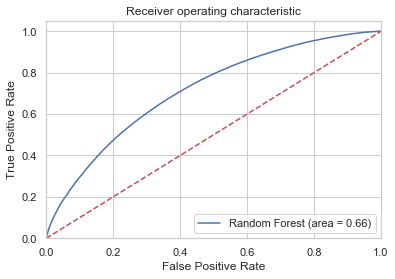

In [29]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1]) #predicted probability of default
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [30]:
# #Reduce to top 20 features and rerun RF

# target = ['loan_status'] 
# rf_final_features = feature_imp_rf[0:20].index.to_list()

# X_train = lc_under_train[rf_final_features]
# y_train = lc_under_train[target]

# X_test = lc_under_test[rf_final_features]
# y_test = lc_under_test[target]

# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
# print(X_train.shape); print(X_test.shape)

# rf.fit(X_train, y_train)

# y_pred_rf = rf.predict(X_test)

In [31]:
# rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
# fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1]) #predicted probability of default
# plt.figure()
# plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [32]:
# #Random Forest Hyper parameter fine tuning

# # Number of trees in random forest
# n_estimators = [500]

# # Number of features to consider at every split
# max_features = ['auto']

# # Maximum number of levels in tree
# max_depth = [10,30]

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]

# rf_grid = {'n_estimators': n_estimators,
#            'max_features': max_features,
#            'max_depth': max_depth,
#            'min_samples_split': min_samples_split,
#            'min_samples_leaf': min_samples_leaf}

# pprint(rf_grid)

# rf=RandomForestClassifier()

# # Perform RandomizedSearchCV
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=42, 
#                                n_jobs = -1)

# # Fit the estimator
# rf_random.fit(X_train, y_train)

# # Compute metrics
# print(rf_random.best_score_)
# print(rf_random.best_estimator_)

In [33]:
#Using the default 0.5 as the threshold for classification

print('Accuracy score = ',metrics.accuracy_score(y_test, y_pred_rf))
print('Precision = ',metrics.precision_score(y_test, y_pred_rf))
print('Recall = ',metrics.recall_score(y_test, y_pred_rf))
print('F1 score = ',metrics.f1_score(y_test, y_pred_rf))

Accuracy score =  0.655006132370543
Precision =  0.6488219660067911
Recall =  0.6757757856368831
F1 score =  0.6620246384574183


Confusion matrix, without normalization
[[64382 37129]
 [32912 68598]]
Normalized confusion matrix
[[0.63423668 0.36576332]
 [0.32422421 0.67577579]]


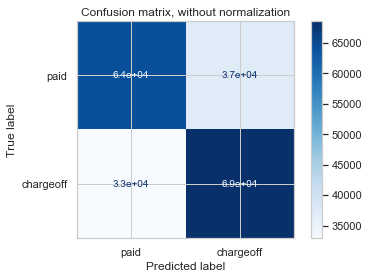

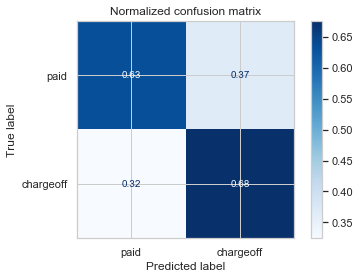

In [34]:
#False Postivie (false alarm) Rate  

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=['paid','chargeoff'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [35]:
#Try AdaBoost

X = lc_under[features]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(X_train.shape); print(X_test.shape)

adaboost = AdaBoostClassifier(n_estimators=200, random_state=42)

adaboost.fit(X_train,y_train)

y_pred = adaboost.predict(X_test)


(473713, 152)
(203021, 152)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


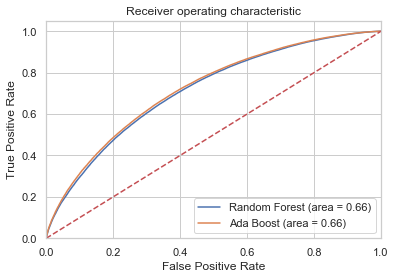

In [36]:
ada_roc_auc = roc_auc_score(y_test, adaboost.predict(X_test))
fpr_ada, tpr_ada, thresholds = roc_curve(y_test, adaboost.predict_proba(X_test)[:,1]) #predicted probability of default
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_ada, tpr_ada, label='Ada Boost (area = %0.2f)' % ada_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

In [37]:
feature_imp_ada = pd.Series(adaboost.feature_importances_,index=features).sort_values(ascending=False)

feature_imp_ada[0:20]

int_rate                 0.135
installment_to_inc       0.055
fico_range_avg           0.055
emp_length               0.040
dti                      0.040
acc_open_past_24mths     0.040
avg_cur_bal              0.030
total_rev_hi_lim         0.025
mths_since_recent_bc     0.025
funded_amnt              0.025
cr_line_months           0.025
mo_sin_old_rev_tl_op     0.020
mths_since_recent_inq    0.020
total_acc                0.020
mort_acc                 0.015
total_bc_limit           0.015
bc_util                  0.015
mo_sin_old_il_acct       0.015
annual_inc               0.015
num_actv_rev_tl          0.010
dtype: float64

In [38]:
#Try XGBOOST

X = lc_under[features]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(X_train.shape); print(X_test.shape)

xgboost = xgb.XGBClassifier(objective ='binary:logistic', max_depth = 3, 
                            n_estimators = 200)

xgboost.fit(X_train,y_train)

y_pred = xgboost.predict(X_test)



(473713, 152)
(203021, 152)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


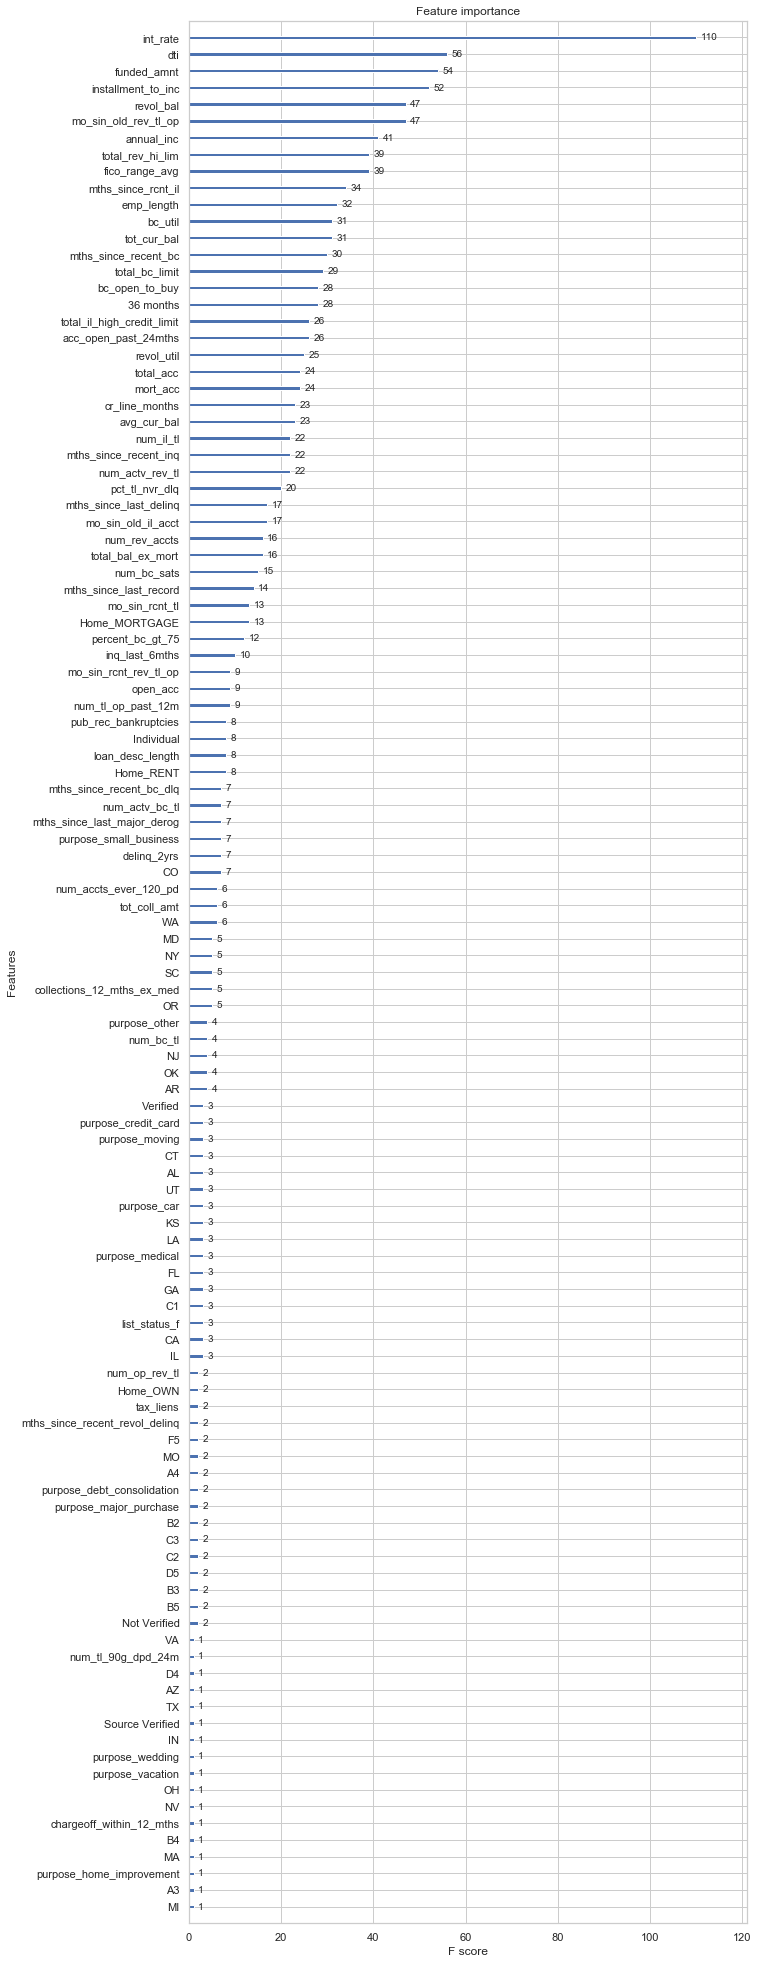

In [56]:
xgb.plot_importance(xgboost)
#plt.rcParams['figure.figsize'] = [10, 45]
plt.show()

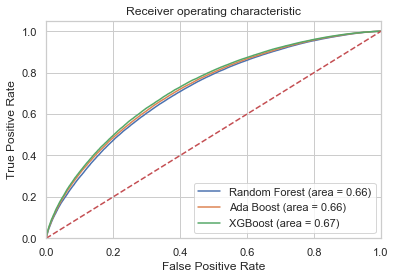

In [40]:
xgb_roc_auc = roc_auc_score(y_test, xgboost.predict(X_test))
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, xgboost.predict_proba(X_test)[:,1]) #predicted probability of default
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_ada, tpr_ada, label='Ada Boost (area = %0.2f)' % ada_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

In [41]:
#Using the default 0.5 as the threshold for classification

print('Accuracy score = ',metrics.accuracy_score(y_test, y_pred))
print('Precision = ',metrics.precision_score(y_test, y_pred))
print('Recall = ',metrics.recall_score(y_test, y_pred))
print('F1 score = ',metrics.f1_score(y_test, y_pred))

Accuracy score =  0.666315307283483
Precision =  0.6613620071684588
Recall =  0.6816569796079204
F1 score =  0.6713561500958111


Confusion matrix, without normalization
[[66081 35430]
 [32315 69195]]
Normalized confusion matrix
[[0.65097379 0.34902621]
 [0.31834302 0.68165698]]


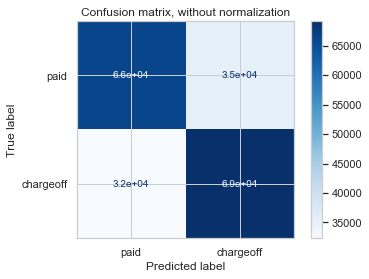

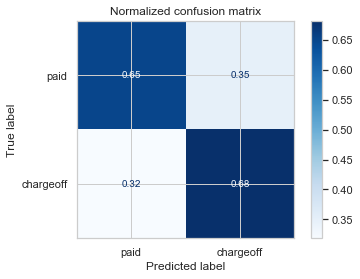

In [42]:
#False Postivie (false alarm) Rate  

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgboost, X_test, y_test,
                                 display_labels=['paid','chargeoff'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [43]:
# #Random Search Hyper parameter fine tuning

# # Create the parameter grid
# xgb_param_grid = {
#     'n_estimators': [200],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
#     'max_depth': np.arange(3, 10, 1),
#     'colsample_bytree': np.arange(.3, 1, .1),
#     'subsample': [.8, .9, 1],
#     'gamma': [0, 1, 5]
# }

# xgboost = xgb.XGBClassifier()
    
# # Perform RandomizedSearchCV
# randomized_roc_auc = RandomizedSearchCV(estimator=xgboost,
#                                         param_distributions=xgb_param_grid,
#                                         n_iter=10, scoring='roc_auc', cv=3, verbose=2,
#                                         random_state=42, n_jobs = 1)

# # Fit the estimator
# randomized_roc_auc.fit(X_train, y_train)

# # Compute metrics
# print(randomized_roc_auc.best_score_)
# print(randomized_roc_auc.best_estimator_)

In [44]:
#Decision Tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

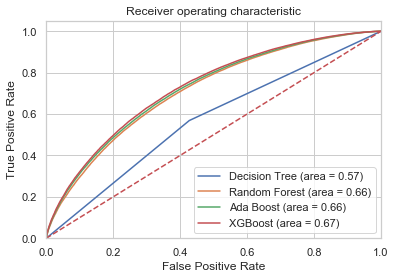

In [45]:
#Comparing AUC, random forest is better than logistic in this case

clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1]) #predicted probability of default
plt.figure()
plt.plot(fpr_clf, tpr_clf, label='Decision Tree (area = %0.2f)' % clf_roc_auc)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_ada, tpr_ada, label='Ada Boost (area = %0.2f)' % ada_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgb_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [46]:
lc_under.head(2)

,funded_amnt,int_rate,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
619983,-0.732557,-0.985452,-0.283745,-1.036682,0,1.422323,-0.363556,-0.709249,-0.797308,-2.080420,-0.492904,1.263934,-0.321875,0.300871,-0.128620,-0.13323,-1.448017,-0.064995,-0.116991,-0.746394,1.090996,-0.499651,0.031372,-0.656297,-0.446418,1.215345,-0.08805,-0.018679,-0.117861,-0.110125,-0.544154,-0.541788,1.336869,0.177169,0.570425,0.033950,0.722749,0.352752,-0.303341,0.651961,-0.589074,-0.810505,-0.072181,-0.078071,-0.405452,-0.176344,0.381667,-1.808105,0.609920,2.192978,-0.131324,-0.544741,-0.542273,-0.624009,0.664434,-0.664434,-0.158071,-0.144738,-0.149135,-0.177096,-0.196404,-0.217784,4.535178,-0.231762,-0.24517,-0.249513,-0.259642,-0.251488,-0.252344,-0.258108,-0.248961,-0.21407,-0.205255,-0.1908,-0.181959,-0.168535,-0.145682,-0.138556,-0.131945,-0.122468,-0.121764,-0.096502,-0.082447,-0.075116,-0.068537,-0.062247,-0.054947,-0.045368,-0.040405,-0.036411,-0.035211,-0.940307,-0.02568,2.813081,-0.847277,-0.641029,1.218922,-0.663148,-0.09586,1.924523,-1.196287,0.0,-0.258704,-0.078045,-0.146537,-0.111595,-0.08584,-0.254161,-0.025565,-0.108018,-0.083359,-0.021234,-0.115992,-0.090337,-0.157071,-0.404622,-0.143718,-0.119952,-0.282890,-0.181421,-0.197831,7.512520,-0.089242,-0.099195,-0.110346,-0.151576,-0.156542,-0.164281,-0.134359,-0.128614,-0.171657,-0.193307,-0.125885,-0.302596,-0.184916,-0.099271,-0.104823,-0.18869,-0.106233,-0.129519,-0.299771,-0.082891,-0.168887,-0.141333,-0.115375,1.393635,-1.393635,0.202278,-0.202278,-0.170441,0.374739,-0.760940,0.448112
1107470,-0.007002,-0.987428,-0.463799,-0.653971,0,0.847389,0.738791,-0.709249,-1.069434,0.462507,0.220115,-0.369964,-0.211598,0.403795,-0.542427,-0.13323,0.624102,-0.064995,-0.116991,-0.665336,-0.940835,-0.401807,0.333870,-0.618761,-0.210597,0.081654,-0.08805,-0.018679,-0.362834,-0.256334,-0.357122,-0.071859,-0.795284,-0.525159,-1.721013,-0.258522,-1.334031,-0.383625,1.422507,0.944153,0.735693,0.245300,-0.739117,0.563395,0.089920,-0.176344,0.381667,-1.212166,-0.050819,-0.372567,-0.131324,-0.290938,-0.159595,-0.114516,0.664434,-0.664434,-0.158071,-0.144738,-0.149135,-0.177096,-0.196404,-0.217784,4.535178,-0.231762,-0.24517,-0.249513,-0.259642,-0.251488,-0.252344,-0.258108,-0.248961,-0.21407,-0.205255,-0.1908,-0.181959,-0.168535,-0.145682,-0.138556,-0.131945,-0.122468,-0.121764,-0.096502,-0.082447,-0.075116,-0.068537,-0.062247,-0.054947,-0.045368,-0.040405,-0.036411,-0.035211,1.063483,-0.02568,-0.355482,-0.847277,-0.641029,1.218922,-0.663148,-0.0958

In [47]:
#Logistic Regression


#RFE Feature Selection
#Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model 
#and choose either the best or worst performing feature, setting the feature aside and then
#repeating the process with the rest of the features.

lc_under['intercept'] = 1

target = ['loan_status'] 
features_logit = list(lc_under.drop(['loan_status',' 60 months','G5','Home_OTHER',
                                              'Source Verified','purpose_educational','AL',
                                              'list_status_w','Joint App'],axis=1).columns)

X = lc_under[features_logit]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features)))


(473713, 145)
(203021, 145)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

Features sorted by their rank:
[(1, ' 36 months'), (1, ' 60 months'), (1, 'G4'), (1, 'Not Verified'), (1, 'Source Verified'), (1, 'VA'), (1, 'WA'), (1, 'WI'), (1, 'acc_open_past_24mths'), (1, 'annual_inc'), (1, 'dti'), (1, 'inq_last_6mths'), (1, 'mo_sin_old_rev_tl_op'), (1, 'mths_since_rcnt_il'), (1, 'num_actv_rev_tl'), (1, 'tot_cur_bal'), (1, 'total_acc'), (1, 'total_bal_ex_mort'), (1, 'total_il_high_credit_limit'), (1, 'total_rev_hi_lim'), (2, 'total_bc_limit'), (3, 'bc_open_to_buy'), (4, 'A1'), (5, 'A3'), (6, 'A2'), (7, 'A4'), (8, 'A5'), (9, 'B1'), (10, 'B2'), (11, 'B3'), (12, 'B4'), (13, 'B5'), (14, 'mort_acc'), (15, 'Home_MORTGAGE'), (16, 'mo_sin_old_il_acct'), (17, 'C1'), (18, 'C2'), (19, 'C3'), (20, 'purpose_vacation'), (21, 'bc_util'), (22, 'percent_bc_gt_75'), (23, 'PA'), (24, 'mths_since_recent_bc'), (25, 'delinq_2yrs'), (26, 'NC'), (27, 'C4'), (28, 'funded_amnt'), (29, 'emp_length'), (30, 'num_bc_sats'), (31, 'open_acc'), (32, 'NV'), (33, 'C5'), (34, 'TX'), (35, 'purpose_maj

In [48]:
#Top 30 features selected from RFE

features_sorted_by_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features))
selected_features = [x[1] for x in features_sorted_by_rank[:30]]
selected_features

[' 36 months',
 ' 60 months',
 'G4',
 'Not Verified',
 'Source Verified',
 'VA',
 'WA',
 'WI',
 'acc_open_past_24mths',
 'annual_inc',
 'dti',
 'inq_last_6mths',
 'mo_sin_old_rev_tl_op',
 'mths_since_rcnt_il',
 'num_actv_rev_tl',
 'tot_cur_bal',
 'total_acc',
 'total_bal_ex_mort',
 'total_il_high_credit_limit',
 'total_rev_hi_lim',
 'total_bc_limit',
 'bc_open_to_buy',
 'A1',
 'A3',
 'A2',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3']

In [49]:

features_logit = [x for x in selected_features+['intercept'] if x not in [' 60 months']]


X = lc_under[features_logit]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

#Use p-value to find the significance of variables
logit_model=sm.Logit(y_train,X_train)

result=logit_model.fit()

print(result.summary2())

C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization terminated successfully.
         Current function value: 0.628406
         Iterations 6
                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.093      
Dependent Variable:     loan_status         AIC:                 595428.5504
Date:                   2020-05-04 21:43    BIC:                 595760.6011
No. Observations:       473713              Log-Likelihood:      -2.9768e+05
Df Model:               29                  LL-Null:             -3.2835e+05
Df Residuals:           473683              LLR p-value:         0.0000     
Converged:              1.0000              Scale:               1.0000     
No. Iterations:         6.0000                                              
----------------------------------------------------------------------------
                            Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
 36 m

In [50]:
#Remove insignificant features

insignificant_features = ['VA','WI','WA','bc_open_to_buy']

features_logit = [x for x in features_logit if x not in insignificant_features]

X = lc_under[features_logit]
y = lc_under[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

#Use p-value to find the significance of variables
logit_model=sm.Logit(y_train,X_train)

result=logit_model.fit()

print(result.summary2())

(473713, 26)
(203021, 26)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization terminated successfully.
         Current function value: 0.628666
         Iterations 6
                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.093      
Dependent Variable:     loan_status         AIC:                 595666.3370
Date:                   2020-05-04 21:43    BIC:                 595954.1143
No. Observations:       473713              Log-Likelihood:      -2.9781e+05
Df Model:               25                  LL-Null:             -3.2835e+05
Df Residuals:           473687              LLR p-value:         0.0000     
Converged:              1.0000              Scale:               1.0000     
No. Iterations:         6.0000                                              
----------------------------------------------------------------------------
                            Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
 36 m

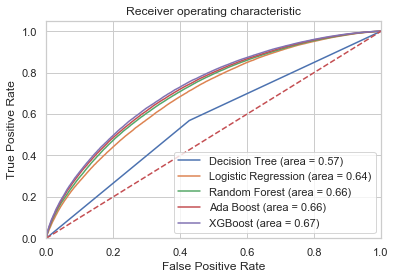

In [51]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr_logit, tpr_logit, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1]) #predicted probability of cancellation
plt.figure()
plt.plot(fpr_clf, tpr_clf, label='Decision Tree (area = %0.2f)' % clf_roc_auc)
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_ada, tpr_ada, label='Ada Boost (area = %0.2f)' % ada_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgb_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [52]:
# # group / ensemble of models 
# estimator = [] 
# estimator.append(('LR', LogisticRegression())) 
# #estimator.append(('CLF', tree.DecisionTreeClassifier()))

# estimator.append(('RF', RandomForestClassifier(n_estimators=200, random_state = 42, 
#                           max_depth = 10))) 
# estimator.append(('ADABOOST', AdaBoostClassifier(n_estimators=200, random_state=42)))
# estimator.append(('XGBOOST', xgb.XGBClassifier(objective ='binary:logistic', max_depth = 3, 
#                             n_estimators = 200)))

# vot_soft = VotingClassifier(estimators = estimator, voting ='soft') 
# vot_soft.fit(X_train, y_train) 
# y_pred = vot_soft.predict(X_test) 

In [53]:
# logit_roc_auc = roc_auc_score(y_test, vot_soft.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1]) #predicted probability of cancellation
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# #plt.plot(fpr_clf, tpr_clf, label='Decision Tree (area = %0.2f)' % clf_roc_auc)
# plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# plt.plot(fpr_gb, tpr_gb, label='Gradient Boost (area = %0.2f)' % xgb_roc_auc)

# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [ ]:
#Resources
#https://www.liebertpub.com/doi/full/10.1089/big.2018.0092

In [54]:
#Next steps: predict the expected loss by combining predicted default rate and LGD